## Baseline evaluation

In [ ]:
from m2_cw import load_qwen, load_and_preprocess, preprocess_series

from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cpu")

# Import qwen model and tokenizer
model, tokenizer = load_qwen()
model.to(device)
print(model.device)

cpu


In [146]:
characters = list("0123456789,.;")
tokens = tokenizer(characters, return_tensors="pt", add_special_tokens=False)
valid_qwen_tokens = tokens.input_ids

qwen_to_forecast_tokens = {
    15: 0,
    16: 1,
    17: 2,
    18: 3,
    19: 4,
    20: 5,
    21: 6,
    22: 7,
    23: 8,
    24: 9,
    11: 10,
    13: 11,
    26: 12,
}

old_embedding_weight = model.model.embed_tokens.weight
new_embedding_weight = None

for qwen_token in valid_qwen_tokens:
    embedding_vector = model.model.embed_tokens.forward(qwen_token)
    forecast_token = torch.tensor([qwen_to_forecast_tokens[qwen_token[0].item()]])

    if new_embedding_weight is None:
        new_embedding_weight = embedding_vector
    else:
        new_embedding_weight = torch.concat((new_embedding_weight, embedding_vector), dim=0)

new_embedding_weight = nn.Parameter(new_embedding_weight)

char = ";"
qwen_token = tokenizer(char, return_tensors="pt", add_special_tokens=False).input_ids.item() # Token for "0"
forecast_token = qwen_to_forecast_tokens[qwen_token] 
print(f"Char: '{char}' | qwen token: {qwen_token} -> forecast token: {forecast_token}")

qwen_embedding = old_embedding_weight[qwen_token]
forecast_embedding = new_embedding_weight[forecast_token]

print(qwen_embedding.shape, qwen_embedding[:4])
print(forecast_embedding.shape, forecast_embedding[:4])

Char: ';' | qwen token: 26 -> forecast token: 12
torch.Size([896]) tensor([-0.0142, -0.0149,  0.0034, -0.0065])
torch.Size([896]) tensor([-0.0142, -0.0149,  0.0034, -0.0065], grad_fn=<SliceBackward0>)


What if we tweak the embedding matrix to only include the valid characters, and therefore tweak the tokens that each has to make them simpler

In [137]:
# Load and preprocess the time serieses
train_texts, val_texts = load_and_preprocess("data/lotka_volterra_data.h5")
test_sequence = train_texts[0][:10]
test_tokens = tokenizer(test_sequence, return_tensors="pt", add_special_tokens=False).input_ids
print(test_sequence)
print(test_tokens)

3.35,3.67;
tensor([[18, 13, 18, 20, 11, 18, 13, 21, 22, 26]])


In [3]:
# Example of text generation

def generate_forecast(prompt, tokenizer, samples=20, steps=20):
    repeated_prompt = [ prompt for i in range(samples) ]
    encoding = tokenizer(repeated_prompt, return_tensors="pt", add_special_tokens=False) # Encode the prompt
    encoding = encoding.to(device)
    prompt_token_length = encoding.input_ids.shape[1]

    with torch.no_grad():
        output = model.generate(**encoding, max_new_tokens=12*steps, do_sample=True, temperature=0.8, renormalize_logits=True) # generate response
    
    responses = output[:, prompt_token_length:] # Clip response to only the new characters
    responses = tokenizer.batch_decode(responses, skip_special_tokens=True)

    responses = [ [ [ float(num) for num in pair.split(",")] for pair in response.split(";")[:steps] ] for response in responses ]
    responses = torch.tensor(responses).median(dim=0).values.numpy()

    forecast = ""

    for pair in responses:
        pred = str(pair[0])
        prey = str(pair[1])

        next_pair = f"{pred},{prey};"
        forecast = forecast + next_pair

    return forecast

original_prompt = train_texts[0]
original_gt = val_texts[0]

forecast = generate_forecast(original_prompt, tokenizer, 3)

torch.Size([20, 2])
torch.Size([60, 2])
torch.Size([20, 2])


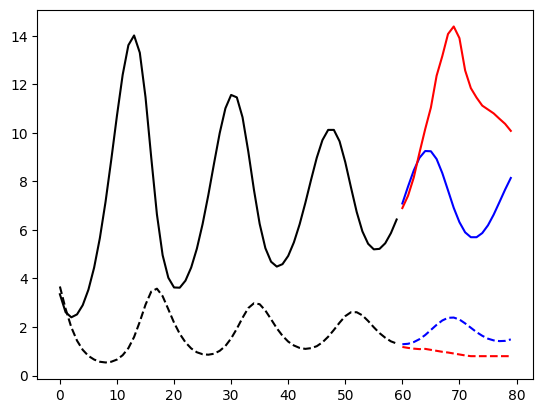

In [4]:
def postprocess(text):
    text = text.split(";")
    text = [ step.split(",") for step in text]
    text = [step for step in text if len(step) == 2]
    text = [ [float(step[0]), float(step[1])] for step in text ]
    text = torch.tensor(text)
    return text

forecast_values = postprocess(forecast)
train_values = postprocess(original_prompt)
val_values = postprocess(val_texts[0])

print(forecast_values.shape)
print(train_values.shape)
print(val_values.shape)

t0 = range(60)
t1 = range(60, 80)

def plot(data, time, color):
    plt.plot(time, data[:, 0], color=color)
    plt.plot(time, data[:, 1], color=color, ls="--")

plot(train_values, t0, "black")
plot(val_values, t1, "blue")
plot(forecast_values, t1, "red")
plt.show();